In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import selfies as sf
%matplotlib inline

In [14]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles_sf = open('data/1to6.dmu.selfies', 'r').read().splitlines()
print(len(smiles_sf))
print(max(len(w) for w in smiles_sf))
print(smiles_sf[-8:])

35466
120
['[N][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][Ring1][Ring1][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]']


In [15]:
# build the vocabulary of selfies tokens and mappings to/from integers
alphabet = sf.get_alphabet_from_selfies(smiles_sf)
#chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '[Ring2]', 2: '[=N]', 3: '[#C]', 4: '[N]', 5: '[O]', 6: '[Branch1]', 7: '[C]', 8: '[=O]', 9: '[=Branch1]', 10: '[#N]', 11: '[=C]', 12: '[Ring1]', 13: '[=Ring1]', 0: '.'}
14


In [16]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles_sf)

In [17]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(smiles_sf):
    X, Y = [], []
    
    for s in smiles_sf:
        context = [0] * block_size
        for vocab in list(sf.split_selfies(s)) + ['.']:
            ix = stoi[vocab]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
n1 = int(0.8 * len(smiles_sf))
n2 = int(0.9 * len(smiles_sf))
Xtr, Ytr = build_dataset(smiles_sf[:n1])
Xdev, Ydev = build_dataset(smiles_sf[n1:n2])
Xte, Yte = build_dataset(smiles_sf[n2:])

torch.Size([275598, 8]) torch.Size([275598])
torch.Size([34690, 8]) torch.Size([34690])
torch.Size([34534, 8]) torch.Size([34534])


In [18]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> [O]
.......[O] --> [N]
......[O][N] --> [N]
.....[O][N][N] --> [=C]
....[O][N][N][=C] --> [Ring1]
...[O][N][N][=C][Ring1] --> [Ring1]
..[O][N][N][=C][Ring1][Ring1] --> [N]
.[O][N][N][=C][Ring1][Ring1][N] --> [=O]
[O][N][N][=C][Ring1][Ring1][N][=O] --> .
........ --> [N]
.......[N] --> [=N]
......[N][=N] --> [C]
.....[N][=N][C] --> [=N]
....[N][=N][C][=N] --> [N]
...[N][=N][C][=N][N] --> [Ring1]
..[N][=N][C][=N][N][Ring1] --> [Ring1]
.[N][=N][C][=N][N][Ring1][Ring1] --> .
........ --> [C]
.......[C] --> [C]
......[C][C] --> [C]


In [19]:
# Create WaveNet model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class makemoreWaveNet(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size * 2, num_hiddens, bias=False)
        self.fc2 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.fc3 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.bn1 = nn.BatchNorm1d(num_hiddens)
        self.bn2 = nn.BatchNorm1d(num_hiddens)
        self.bn3 = nn.BatchNorm1d(num_hiddens)
        self.tanh = nn.Tanh()
        self.fc_fin = nn.Linear(num_hiddens, vocab_size)
        
        

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0] * x.shape[1]//2, x.shape[2]*2)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.tanh(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh(x)
    
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.tanh(x)

        x = self.fc_fin(x)
        return x 

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
n_embd = 10
n_hidden = 100
batch_size = 64

idx = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[idx], Ytr[idx]

model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
x = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([64, 14]) 44154


In [22]:
max_steps = 210000
ini_lr = 3e-4
model = makemoreWaveNet(vocab_size, n_embd, n_hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr)

lossi = []

for i in range(max_steps):
    # Sample a batch of data
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx].to(device), Ytr[idx].to(device)
    
    # train the model
    model.train()
    optimizer.zero_grad()
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    # backprop
    loss.backward()
    optimizer.step()
    
    # Save checkpoint every 50,000 iterations
    modelName = 'Selfies_WaveNet'
    if i % 50000 == 0 and i > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': i
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{i}.pt')
        print(f'Checkpoint saved at iteration {i}')
    
    if i > 100000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4

      0/ 210000: 2.6141
  10000/ 210000: 1.2299
  20000/ 210000: 1.2517
  30000/ 210000: 0.9289
  40000/ 210000: 0.9105
  50000/ 210000: 1.1553
Checkpoint saved at iteration 50000
  60000/ 210000: 1.1944
  70000/ 210000: 1.0150
  80000/ 210000: 1.2012
  90000/ 210000: 1.0268
 100000/ 210000: 1.2764
Checkpoint saved at iteration 100000
 110000/ 210000: 1.2418
 120000/ 210000: 1.0890
 130000/ 210000: 1.1442
 140000/ 210000: 1.1098
 150000/ 210000: 1.1701
Checkpoint saved at iteration 150000
 160000/ 210000: 1.1201
 170000/ 210000: 1.2555
 180000/ 210000: 0.9524
 190000/ 210000: 1.1274
 200000/ 210000: 1.2244
Checkpoint saved at iteration 200000


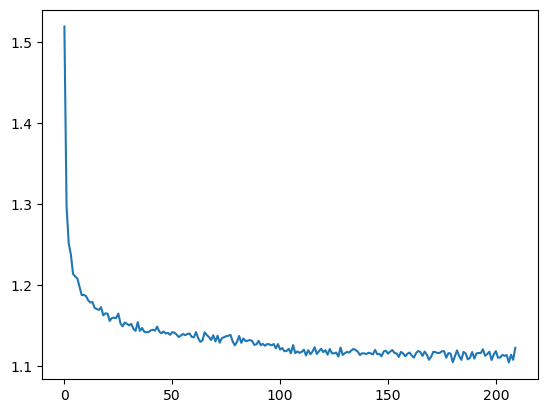

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [24]:
# Load the model from checkpoint
checkpoint = torch.load('models/Selfies_WaveNet_checkpoint_200000.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on train and dev sets
model.to('cpu')
model.eval()
total_params = sum(p.numel() for p in model.parameters())   
print(f'{total_params:,} total parameters.')
with torch.no_grad():
    logits = model(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    print('train', loss.item())
    logits = model(Xdev)
    loss = F.cross_entropy(logits, Ydev)
    print('dev', loss.item())

44,154 total parameters.
train 1.1092604398727417
dev 1.1273438930511475


In [25]:
# sample from the model
checkpoint = torch.load('models/Selfies_WaveNet_checkpoint_200000.pt')
block_size = 8
vocab_size = 14
n_embd = 10
n_hidden = 100
model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
genList = []
with torch.no_grad():
    for _ in range(10000):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        
        genList.append(''.join(itos[i] for i in out).replace('%','')) # decode and collect the generated smiles

In [26]:
genList

['[N][N][N][N][N][Ring1][Ring2][N][Ring1][=Branch1][Ring1][Ring2].',
 '[O][C][C][=C][C][C][Ring1][Branch1][Ring1][Ring1].',
 '[C][C][N][Branch1][C][O][O].',
 '[C][N][O][N][N][N].',
 '[O][=N][C][=C][C][C][Ring1][Ring2].',
 '[N][C][=C][=N][O][Ring1][Ring2].',
 '[C][=C][=C][N][=C][=O].',
 '[N][O][C][N][C][N][Ring1][Ring2].',
 '[C][O][N][N][N][O][Ring1][Ring2].',
 '[C][C][=C][N][N][N][Ring1][Branch1][Ring1][Ring2].',
 '[N][N][=C][=C][=N].',
 '[N][C][#C][N][C][=N].',
 '[N][O][O][N][Branch1][C][N][O].',
 '[C][N][C][=Branch1][C][=N][N][=C].',
 '[O][=C][O][N][O][Ring1][Ring2].',
 '[N][C][C][N][N][N][Ring1][Branch1].',
 '[N][C][=C][N][N][N][Ring1][=Branch1][Ring1][Ring1].',
 '[N][=N][O][C][N][=O].',
 '[C][=C][C][N][=C][=C].',
 '[C][C][C][Branch1][C][C][N][Ring1][Ring2][N].',
 '[C][N][=C][N][=C][Ring1][Ring1][O].',
 '[N][N][Branch1][C][N][N][N][O][Ring1][Ring1].',
 '[C][N][N][C][Ring1][Ring1][N][=N].',
 '[N][=C][N][N][=C][Ring1][Ring2][Ring1][Ring1].',
 '[C][=N][C][O][O].',
 '[O][N][=C][O][C][#C

In [33]:
# Check for validity
from rdkit import Chem
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

validCount = 0
uniqueList = []
for s in genList:
    if Chem.MolFromSmiles(sf.decoder(s)):
        validCount += 1
        canonicalSmiles = Chem.MolToSmiles(Chem.MolFromSmiles(sf.decoder(s)))
        if canonicalSmiles not in uniqueList:
            uniqueList.append(canonicalSmiles) 
print(f"Valid SMILES: {validCount}/{len(genList)}")
print(f"Unique SMILES: {len(uniqueList)}/{validCount}")

Valid SMILES: 10000/10000
Unique SMILES: 8558/10000


In [34]:
import rdkit
print(rdkit.__version__)

2024.03.3


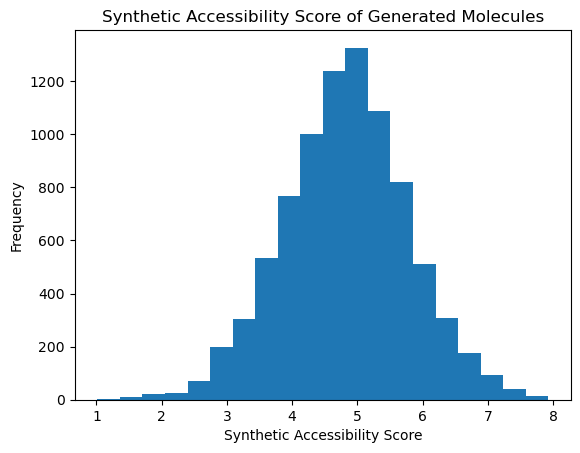

In [35]:
# Compute synthetic accessibility score 
import sys, os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()

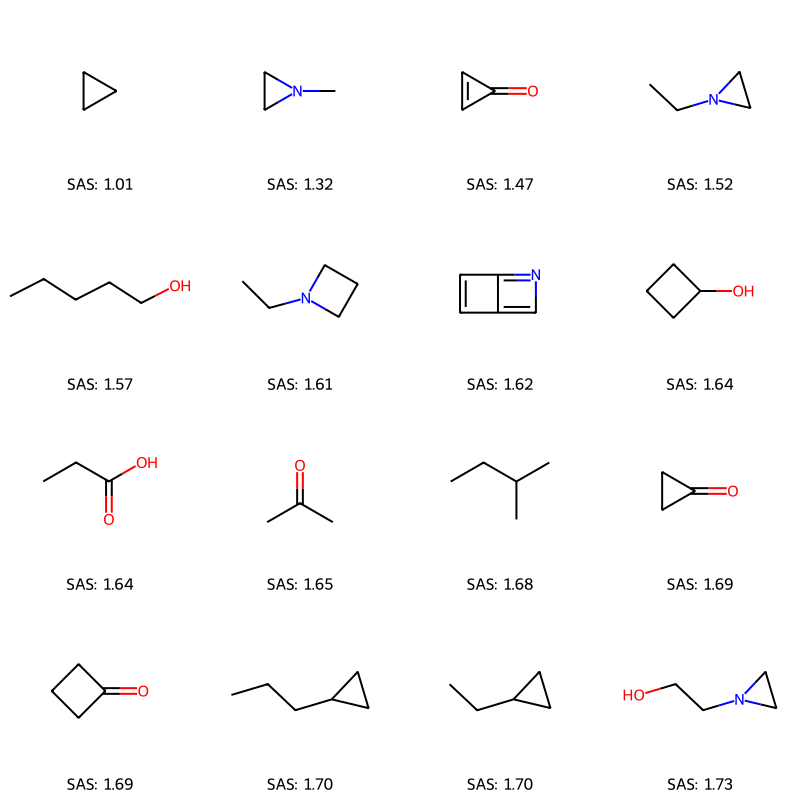

In [39]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

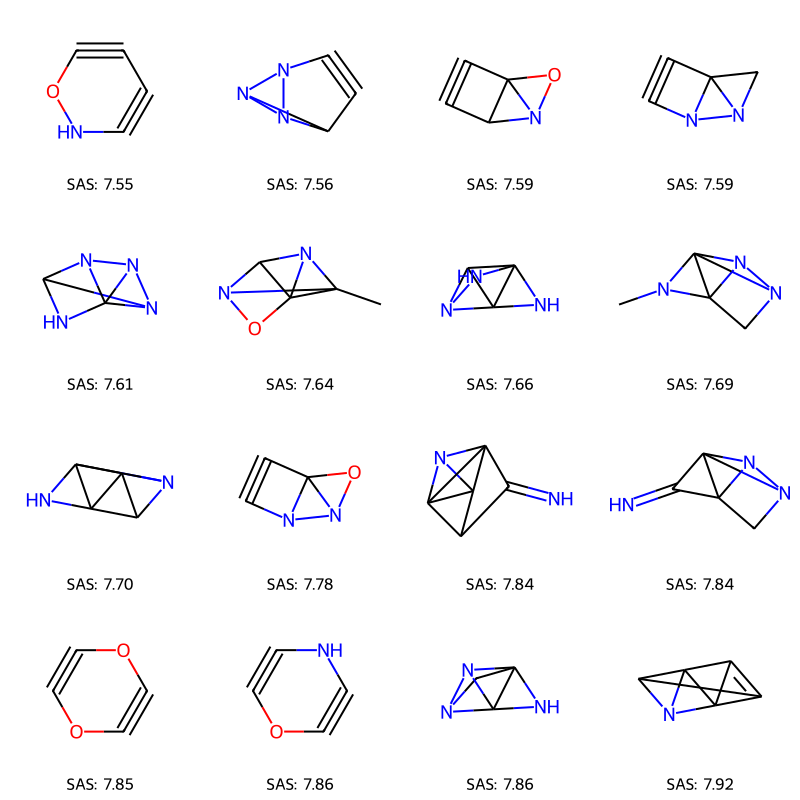

In [37]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])